/var/folders/3g/2wscfy492xv8p55yn6b0rthw0000gn/T/ipykernel_39822/3500667393.py:18: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(conv.weight, 0, 0.02)
/var/folders/3g/2wscfy492xv8p55yn6b0rthw0000gn/T/ipykernel_39822/3500667393.py:39: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(convT.weight, 0, 0.02)


torch.Size([2, 3, 256, 256])
torch.Size([2, 64, 128, 128])
torch.Size([2, 128, 64, 64])
torch.Size([2, 256, 32, 32])
torch.Size([2, 512, 16, 16])
torch.Size([2, 512, 8, 8])
torch.Size([2, 512, 4, 4])
torch.Size([2, 512, 2, 2])


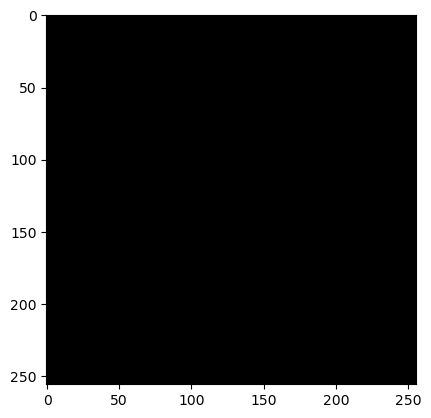

In [26]:
import torch
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from preprocess import GetDataset
import random

dataset = GetDataset()


OUTPUT_CHANNELS = 3

def downsample(in_channels, out_channels, size, padding=1, apply_batchnorm=True):
    #3 in_channels, 3 out_channels, 4x4 size, 2 stride
    conv = torch.nn.Conv2d(in_channels, out_channels, size, stride=2, padding=padding, bias=False)
    torch.nn.init.normal(conv.weight, 0, 0.02)

    #expected 3 channels
    batchnorm = torch.nn.BatchNorm2d(out_channels) 
    leakyrelu = torch.nn.LeakyReLU()
    
    def call(x):
        print(x.shape)
        x = conv(x)
        if apply_batchnorm:
            x = batchnorm(x)
        x = leakyrelu(x)
        return x

    return call



def upsample(in_channels, out_channels, size, apply_dropout=False):
    #3 in_channels, 3 out_channels, 4x4 size, 2 stride
    convT = torch.nn.ConvTranspose2d(in_channels, out_channels, size, stride=2, bias=False)
    torch.nn.init.normal(convT.weight, 0, 0.02)

    # No batchnorm if out_channel is of size 1
    batchnorm = torch.nn.BatchNorm2d(out_channels) 
    relu = torch.nn.ReLU()
    dropout = torch.nn.Dropout()

    def call(x):
        x = convT(x)
        x = batchnorm(x)
        if apply_dropout:
            x = dropout(x)
        x = relu(x)
        return x
    
    return call

#inputs go here

# down_model = downsample(None)
# up_model = upsample(None)

class Generator(torch.nn.Module):

    def __init__(self):
        super().__init__()

        # inputs = torch.tensor(np.zeros(3,256,256))
        self.down_stack = [
            downsample(3, 64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
            downsample(64, 128, 4),  # (batch_size, 64, 64, 128)
            downsample(128, 256, 4),  # (batch_size, 32, 32, 256)
            downsample(256, 512, 4),  # (batch_size, 16, 16, 512)
            downsample(512, 512, 4),  # (batch_size, 8, 8, 512)
            downsample(512, 512, 4),  # (batch_size, 4, 4, 512)
            downsample(512, 512, 4),  # (batch_size, 2, 2, 512)
            downsample(512, 512, 4),  # (batch_size, 1, 1, 512)
        ]

        self.up_stack = [
            upsample(512, 512, 2, apply_dropout=True),  # (batch_size, 2, 2, 1024)
            upsample(1024, 512, 2, apply_dropout=True),  # (batch_size, 4, 4, 1024)
            upsample(1024, 512, 2, apply_dropout=True),  # (batch_size, 8, 8, 1024)
            upsample(1024, 512, 2),  # (batch_size, 16, 16, 1024)
            upsample(1024, 256, 2),  # (batch_size, 32, 32, 512)
            upsample(512, 128, 2),  # (batch_size, 64, 64, 256)
            upsample(256, 64, 2),  # (batch_size, 128, 128, 128)
        ]

        self.last = torch.nn.ConvTranspose2d(128, 3, 2, stride=2, bias=False)
        self.tanh = torch.nn.Tanh()

    # torch.nn.init.normal(last.weight, 0, 0.02)

    def forward(self, x):
        # Downsampling through the model
        skips = []
        
        for down in self.down_stack:
            x = x.to(torch.float32)
            x = down(x)
            skips.append(x)

        skips = reversed(skips[:-1])

        # Upsampling and establishing the skip connections
        for up, skip in zip(self.up_stack, skips):
            x = up(x)
            # Concate skip with upsampled along channels dimension
            x = torch.cat((x, skip), 1)


        x = self.last(x)
        x = self.tanh(x)

        return x

    # return torch.nn.Model(inputs=inputs, outputs=x)

generator = Generator()

inputs = torch.tensor(np.zeros((2,3,256,256)))
np_im = np.transpose(generator(inputs)[0].detach().numpy(), (1,2,0)) / 255
plt.imshow(np_im)
LAMBDA = 10

loss_object = torch.nn.BCELoss()

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(disc_generated_output, torch.ones_like(disc_generated_output))

    # mean absolute error
    l1_loss = torch.mean(torch.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

# Define the Discriminator
class Discriminator(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.down1 = downsample(6, 64, 4, apply_batchnorm=False)
        self.down2 = downsample(64, 128, 4)
        self.down3 = downsample(128, 256, 4)

        self.zero_pad1 = torch.nn.ZeroPad2d(1)
        self.conv = torch.nn.Conv2d(256, 512, 4, stride=1, bias=False)

        self.batchnorm = torch.nn.BatchNorm2d(512)
        self.leaky_relu = torch.nn.LeakyReLU()

        self.zero_pad2 = torch.nn.ZeroPad2d(1)

        self.last = torch.nn.Conv2d(512, 1, 4, stride=1, bias=False)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, inp, tar):
        x = torch.cat((inp, tar), 1)
        x = x.to(torch.float32)
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)

        x = self.zero_pad1(x)
        x = self.conv(x)

        x = self.batchnorm(x)
        x = self.leaky_relu(x)

        x = self.zero_pad2(x)

        x = self.last(x)

        return x
    
discriminator = Discriminator()
    
# Define discriminator loss
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(disc_real_output, torch.ones_like(disc_real_output))

    generated_loss = loss_object(disc_generated_output, torch.zeros_like(disc_generated_output))

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss


# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))


In [27]:
# Training
def train_step(input_images, targets, batch_size=2):



    input_batch = input_images
    target_batch = targets 

    with torch.autograd.set_detect_anomaly(True):
        print(input_batch.shape)
        gen_output = generator(input_batch)

        disc_real_output = discriminator(input_batch, target_batch)
        disc_generated_output = discriminator(input_batch, gen_output)

        gen_loss, gan_loss, l1_loss = generator_loss(disc_generated_output, gen_output, target_batch)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        discriminator_optimizer.zero_grad()
        disc_loss.backward(retain_graph=True)
        discriminator_optimizer.step()

        gen_output = generator(input_batch)

        disc_real_output = discriminator(input_batch, target_batch)
        disc_generated_output = discriminator(input_batch, gen_output)

        gen_loss, gan_loss, l1_loss = generator_loss(disc_generated_output, gen_output, target_batch)

        generator_optimizer.zero_grad()
        gen_loss.backward(retain_graph=True)
        generator_optimizer.step()

        # total_seen += batch_size

        # total_gen_loss += gen_loss
        # total_gan_loss += gan_loss
        # total_l1_loss += l1_loss
        # total_disc_loss += disc_loss

        # avg_gen_loss = float(total_gen_loss / total_seen)
        # avg_gan_loss = float(total_gan_loss / total_seen)
        # avg_l1_loss = float(total_l1_loss / total_seen)
        # avg_disc_loss = float(total_disc_loss / total_seen)

        print(f"\r[gen_loss={gen_loss:.3f}\t disc_loss: {disc_loss:.3f}", end='')
    
    return gen_loss, gan_loss, l1_loss, disc_loss

def fit(train_ds, test_ds, epochs):
    train_elevation_imgs, train_satellite_imgs = convert_ds_to_tensor(train_ds)
    test_elevation_imgs, test_satellite_imgs = convert_ds_to_tensor(test_ds)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        train_step(train_elevation_imgs, train_satellite_imgs)
        generate_images(generator, test_elevation_imgs, test_satellite_imgs)
        if epoch % 5 + 1 == 0:
            generate_images(generator, test_elevation_imgs, test_satellite_imgs)

def convert_ds_to_tensor(ds):
    elevation_imgs = []
    satellite_imgs = []
    for i in range(len(ds)):
        elevation_imgs.append(ds[i]['elevation'])
        satellite_imgs.append(ds[i]['satellite'])
    
    elevation_imgs = torch.stack(elevation_imgs)
    satellite_imgs = torch.stack(satellite_imgs)

    return elevation_imgs, satellite_imgs

In [28]:

if __name__ == '__main__':
    print('<-----------------Runnin----------------->')
    elevation_imgs, satellite_imgs = convert_ds_to_tensor(dataset)
    fit(dataset, dataset, 10)
    generate_images(generator, test_elevation_imgs, test_satellite_imgs)

<-----------------Runnin----------------->

Epoch 1/10
torch.Size([288, 3, 256, 256])
torch.Size([288, 3, 256, 256])
torch.Size([288, 64, 128, 128])
torch.Size([288, 128, 64, 64])
torch.Size([288, 256, 32, 32])
torch.Size([288, 512, 16, 16])
torch.Size([288, 512, 8, 8])
torch.Size([288, 512, 4, 4])
torch.Size([288, 512, 2, 2])
torch.Size([288, 6, 256, 256])
torch.Size([288, 64, 128, 128])
torch.Size([288, 128, 64, 64])
torch.Size([288, 6, 256, 256])
torch.Size([288, 64, 128, 128])
torch.Size([288, 128, 64, 64])


RuntimeError: all elements of input should be between 0 and 1

In [6]:
# Generate images
def generate_images(model, test_input, tar):
    prediction = model(test_input)
    print("generating images")
    plt.figure(figsize=(15, 15))

    i = np.random.randint(0, test_input.shape[0])

    input_img = np.moveaxis(test_input[i].detach().numpy(), 0, 2)
    ground_img = np.moveaxis(tar[i].detach().numpy(), 0, 2)
    pred_img = np.moveaxis(prediction[i].detach().numpy(), 0, 2)

    display_list = [input_img, ground_img, pred_img]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()
